In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

from itertools import combinations
from collections import Counter

In [2]:
df = pd.read_csv('diabetes.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      442 non-null    float64
 1   sex      442 non-null    float64
 2   bmi      442 non-null    float64
 3   bp       442 non-null    float64
 4   s1       442 non-null    float64
 5   s2       442 non-null    float64
 6   s3       442 non-null    float64
 7   s4       442 non-null    float64
 8   s5       442 non-null    float64
 9   s6       442 non-null    float64
 10  disease  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [3]:
train_data, test_data = train_test_split(df, train_size=0.8) # defensive
train_X = train_data.drop('disease', axis=1)
train_y = train_data['disease']
    
test_X = test_data.drop('disease', axis=1)
test_y = test_data['disease']

In [4]:
lm = LinearRegression()
lm.fit(train_X, train_y)

lasso = Lasso(alpha=0.1)
lasso.fit(train_X, train_y)

print(f'OLS train MSE: {round(mean_squared_error(train_y, lm.predict(train_X)),4)}'
      f'    Lasso train MSE: {round(mean_squared_error(train_y, lasso.predict(train_X)),4)}'
      f'\nOLS test MSE:  {round(mean_squared_error(test_y, lm.predict(test_X)),4)}'
      f'    Lasso test MSE:  {round(mean_squared_error(test_y, lasso.predict(test_X)),4)}')

OLS train MSE: 2876.0749    Lasso train MSE: 2939.5803
OLS test MSE:  2820.2195    Lasso test MSE:  2891.1311


In [7]:
def feature_removal(dataframe):

    corr_matrix = dataframe.corr()
    correlations = set()


    for f1, f2 in combinations(corr_matrix.columns, r=2):
        value = corr_matrix[f1][f2]
        if value > 0.6:
            # add correlation (feature1, feature2, value)
            correlations.add(tuple([f1, f2, value]))

    remove_feature = set()

    while correlations:
        features = [f for cor in correlations for f in cor[:2]]

        # finding maximum feature count
        count_features = dict(Counter(i for i in features))
        sorted_features = {k: v for k, v in sorted(count_features.items(), key=lambda item: item[1], reverse=True)}
        max_count = max(sorted_features.values())

        most_correlated = [f for f, count in sorted_features.items() if count == max_count]

        highest = None
        corr_value = 0
        for feature, c in zip(most_correlated, correlations):
            if corr_value < c[2] and (feature == c[0] or feature == c[1]):
                    highest = feature
                    corr_value = value

        remove_feature.add(highest)

        correlations = {corr for corr in correlations if corr[0] != highest and corr[1] != highest}

    return(remove_feature)
    
print(feature_removal(df))

{'s4', 's1'}


In [8]:
train_X_r, test_X_r = train_X.drop(feature_removal(df), axis=1), test_X.drop(feature_removal(df), axis=1)
lm.fit(train_X_r, train_y)

print(f'OLS train MSE: {round(mean_squared_error(train_y, lm.predict(train_X_r)),4)}'
      f'\nOLS test  MSE: {round(mean_squared_error(test_y, lm.predict(test_X_r)),4)}')

OLS train MSE: 2911.7826
OLS test  MSE: 2802.8875


In [9]:
# using numpy for calculation of eigenvalues and eigenvectors
e_val, e_vec = np.linalg.eig(train_X.to_numpy().T @ train_X.to_numpy())

# calculate most important eigenvectors based on eigenvalues
max_e_vec = sorted(enumerate(e_val / sum(e_vec)), key=lambda x: x[1], reverse=True)

In [10]:
# dimensions = 2
max_e_vec_i = [index for index, _ in max_e_vec[:2]]

# transpose
w = e_vec[max_e_vec_i].T

# reduce
train_X_PCA = train_X.to_numpy() @ w
test_X_PCA = test_X.to_numpy() @ w

In [11]:
# Lösung wird deutlich schlechter wenn man Variablen weglässt
# Modell wird einfacher


lm.fit(train_X_PCA, train_y)

print(f'OLS train MSE: {round(mean_squared_error(train_y, lm.predict(train_X_PCA)),4)}'
      f'\nOLS test  MSE: {round(mean_squared_error(test_y, lm.predict(test_X_PCA)),4)}')

OLS train MSE: 5363.7898
OLS test  MSE: 5625.2946


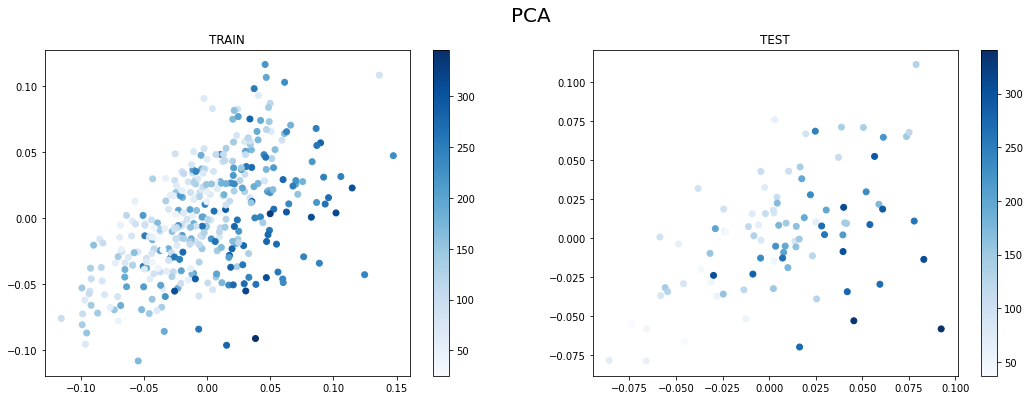

In [75]:
# bei zwei Dimensionen verliert man zu viel "Erklärung"
# zu viel Reduzierung

subplot_args = { 'nrows': 1, 'ncols': 2, 'figsize': (18, 6)}
fig,ax = plt.subplots(**subplot_args)
fig.suptitle("PCA", fontsize=20)

sc1 = ax[0].scatter(*zip(*train_X_PCA), c=train_y, cmap='Blues')
ax[0].set_title('TRAIN')
fig.colorbar(sc1, ax=ax[0])

sc2 = ax[1].scatter(*zip(*test_X_PCA), c=test_y, cmap='Blues')
ax[1].set_title('TEST')
fig.colorbar(sc2, ax=ax[1])